# Classification of types of iris plan based on UCI iris data set

In [312]:
### Imports
from sklearn import datasets

import pandas as pd
import numpy  as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

random_state = 3927

## 01 BUSINESS UNDERSTANDING

1. Data source: [UCI Repoistory](https://archive.ics.uci.edu/ml/datasets/iris)
2. 3 types of plant of 50 instances each, each class refer type of iris plant
3. One type of plant is linearly separable from others and later is not linearly separable from each other
4. Predictive variables are sepal length & width and petal length & width
5. 3 types of iris plant are Setosa, Versicolour and Virginica
6. petal length and width has high correlation with types of plant
7. Error in 35th and 38th sample is to be corrected. Refer the description

## 02 DATA MINING

In [313]:
### Load iris dataset - data is sourced from sklearn datasets
(iris_data, iris_target) = datasets.load_iris(return_X_y = True)  # return tuble of data, target

In [314]:
### load into pandas dataframe
iris_columns = ["sepal length", "sepal width", "petal length", "petal width"]
iris = pd.DataFrame(data = iris_data, columns = iris_columns)
iris['species'] = iris_target
iris['species names'] = np.where(iris_target==0, "Setosa", np.where(iris_target==1, "Versicolour","Virginica"))

In [315]:
### Correction of errors in feature values (35th and 38th sample)
iris.iloc[[34],:] = [4.9,3.1,1.5,0.2,0,"Setosa"]
iris.iloc[[37],:] = [4.9,3.6,1.4,0.1,0,"Setosa"]

## 03 DATA CLEANING

#### Initial observations
1. No categorical variables
2. No missing values
3. presence of outlier to be examined

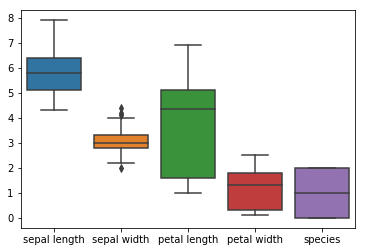

In [316]:
### examining the outlier
### plot histogram
sns.boxplot(data=iris)

In [317]:
def outlier_summary(df):
    per_25 = np.percentile(df, 25, axis=0)
    per_75 = np.percentile(df, 75, axis=0)
    iqr = per_75-per_25
    lower_fence = per_25-1.5*iqr
    upper_fence = per_75 + 1.5*iqr
    columns = df.columns
    per_val_lower = (df < lower_fence).mean()*100
    per_val_upper = (df > upper_fence).mean()*100
    outlier = pd.DataFrame( data = [lower_fence,per_val_lower,upper_fence,per_val_upper])
    outlier.columns = columns
    outlier.index =["lower","per_low_upper","upper","per_val_upper"]
    return outlier

In [318]:
outlier_summary(iris.iloc[:,0:4])

,sepal length,sepal width,petal length,petal width
lower,3.15,2.050000,-3.65,-1.95
per_low_upper,0.00,0.666667,0.00,0.00
upper,8.35,4.050000,10.35,4.05
per_val_upper,0.00,2.000000,0.00,0.00


#### Outlier key take-aways
1. outlier is found only for sepal width and is about 0.6% and 2% respectively and hence no treatment is needed
<br>
<font color = "red"> <b>  No outlier treatment is needed </b></font>

## 04 DATA EXPLORATION

#### Objectives
1. Correlation among predictive variables and between target variable to be examined
2. Univariate analysis - distribution

#### Function to return correlation summary

In [319]:
def corr_summary(df, threshold):
    df_corr = df.corr()
    ### make diagnoal and below diagnoal is zero and built dataframe
    df_corr = pd.DataFrame(columns = df_corr.columns, index = df_corr.index, data = np.triu(df_corr,1))
    ### unstack and sort descending
    df_corr = df_corr.unstack().sort_values(ascending = False)
    ### retain rows whose correlation values within the threshold
    df_corr = pd.concat([df_corr[df_corr <= -threshold],df_corr[df_corr >= threshold]])
    ### retain rows where correlation is not zero and resetting the index
    df_corr = df_corr[df_corr!=0].reset_index()
    ### add columns name
    df_corr.columns = ["feature1", "feature2", "value"]
    return df_corr

In [320]:
corr_summary(iris,0.5)

,feature1,feature2,value
0,petal width,petal length,0.962865
1,species,petal width,0.956547
2,species,petal length,0.949035
3,petal length,sepal length,0.871754
4,petal width,sepal length,0.817941
5,species,sepal length,0.782561


[(0, 1.1)]

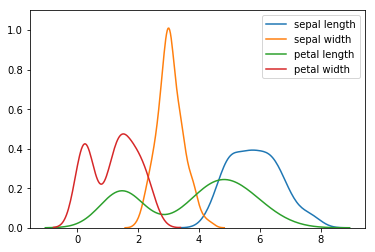

In [321]:
#### Univariate analysis
for var in range(iris.shape[1]-2):
    g = sns.kdeplot(iris.iloc[:,var])
g.set(ylim=(0,1.1))

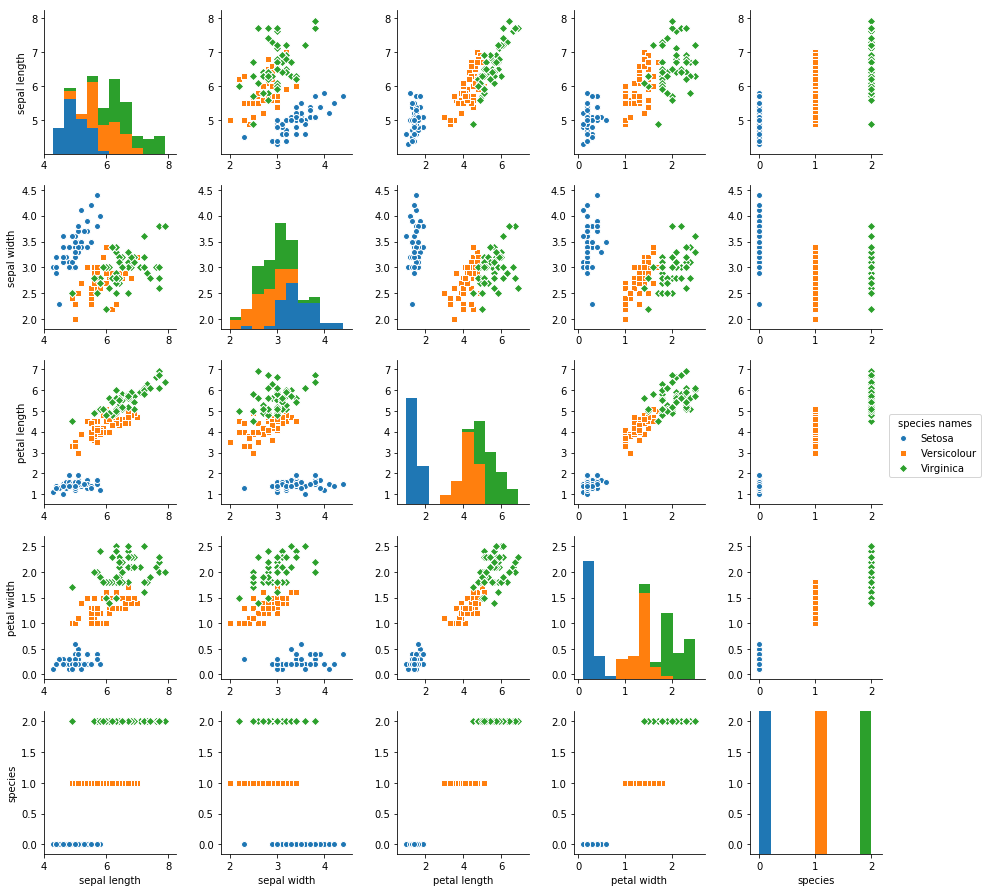

In [322]:
sns.pairplot(iris, hue = "species names", markers=["o", "s", "D"],kind = "scatter", diag_kind = "hist")

####  key take-aways
1. Setosa can be linearly separated from other flowers
2. veriscolor and virginca can't be separted linearly..
<br>
<font color = "red"> <b>  petal width, petal length would be deciding factor for determining types of iris plant </b></font>

## 05 FEATURE ENGINEERING

#### Interaction variables
1. Create petal area = petal width * petal length to compute petal area (just apporimated to rectangle)

In [323]:
iris["petal area"] = (iris["petal length"]  * iris["petal width"]) 
features_to_keep = ["petal area", "sepal length","sepal width","species", "species names"]

In [324]:
corr_summary(iris[features_to_keep],0.7)

,feature1,feature2,value
0,species,petal area,0.950123
1,sepal length,petal area,0.857300
2,species,sepal length,0.782561


###### outlier_summary


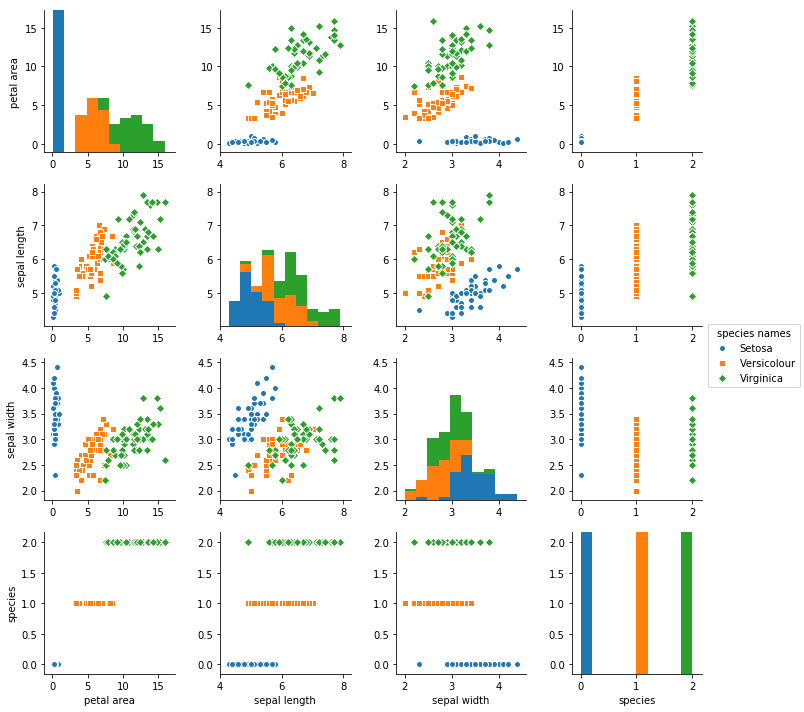

In [325]:
sns.pairplot(iris[features_to_keep], hue = "species names", markers=["o", "s", "D"],kind = "scatter", diag_kind = "hist")

#### Feature engineering key take-aways
<font color = "red"> <b> petal area is strong factor to decide species. Little overlap is observed between veriscolour and viginica flowers </b></font>

In [326]:
features_to_keep = ["petal area"]

## 06 PREDICTIVE MODELLING

#### Preprocessing

In [327]:
from sklearn.preprocessing import label_binarize
from sklearn import neighbors, datasets, preprocessing
from sklearn.multiclass import OneVsRestClassifier

In [328]:
# Binarize the output
iris_species2 = label_binarize(iris.species, classes=[0, 1, 2])

In [329]:
### lets split train - test data
X_train, X_test, y_train, y_test = train_test_split(iris[features_to_keep],iris_species2, test_size=0.3, random_state=random_state, stratify =iris.species )

In [330]:
# Standarize the input
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
y_test = y_test
y_train = y_train

#### Train iris data using RandomForestClassifier

In [331]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

In [332]:
#Create Random Forest object
model= OneVsRestClassifier(RandomForestClassifier(random_state = random_state))
#Train the model using the training sets and check score
model.fit(X_train, y_train)
#Predict Output
y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)

#### Compute metrics
1. accuracy
2. roc-auc

In [333]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [334]:
# accuracy score
train_score = accuracy_score(y_train, y_train_predicted)
test_score = accuracy_score(y_test, y_test_predicted)
[train_score, test_score]

[0.99047619047619051, 0.97777777777777775]

In [335]:

pred = model.predict_proba(X_train)
print('RF train roc-auc: {}'.format(roc_auc_score(y_train, pred,average = None)))
pred = model.predict_proba(X_test)
print('RF test roc-auc: {}'.format(roc_auc_score(y_test, pred, average = None)))


RF train roc-auc: [ 1.          0.99959184  0.99959184]
RF test roc-auc: [ 1.          0.99777778  0.99777778]


## 07 CONCLUSION

In [418]:
nclasses = 3
iris_flowers = []
for species in range(nclasses):
    flower = scaler.inverse_transform(X_test[y_test[:,species] == 1]).flatten()
    iris_flowers.append(flower)

iris_flowers = pd.DataFrame(iris_flowers).T

iris_flowers.describe()

,0,1,2
count,15.000000,15.000000,15.000000
mean,0.311333,6.149333,11.032667
std,0.143271,1.177494,2.298004
min,0.140000,4.290000,7.650000
25%,0.280000,5.395000,9.230000
50%,0.280000,6.160000,10.440000
75%,0.300000,6.975000,12.930000
max,0.760000,8.500000,15.000000


#### Petal area is key feature to decide the type of iris
<font color = "red"> <b> petal area = 8.5 got misclassified for both veriscolour and viginica flowers </b></font>


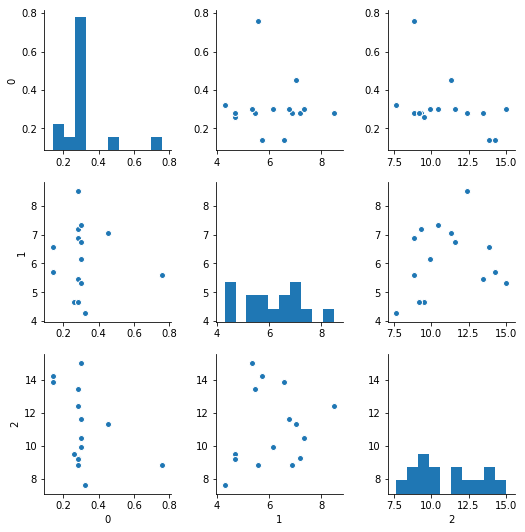